# Wildfire Detection - by Selman Tabet @ https://selman.io/

In [1]:
import os
import time


### Environment Setup

In [2]:
print(os.getcwd())

d:\Dissertation\Kaggle Data\wildfire-detection


In [3]:
import socket
print(socket.gethostname())
import os
try: # for CUDA enviroment
    os.system("nvidia-smi")
except:
    pass

Chaos


### Importing Libraries

In [4]:
# Data processing libraries
import numpy as np
import pandas as pd
from itertools import combinations
import json

# ML libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow.keras.backend as K
from keras.metrics import Precision, Recall, AUC

# Chart generating libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

# from train_parameters import *
from customnet import *

d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Environment Setup

In [5]:
DATASETS = {
    "dataset_1": {
        "train": os.path.join("dataset_1", "train"),
        "test": os.path.join("dataset_1", "test"),
        "val": os.path.join("dataset_1", "val"),
        "augment": False
    },
    "dataset_2": {
        "train": os.path.join("dataset_2", "Training and Validation"),
        "test": os.path.join("dataset_2", "Testing"),
        "augment": False
    },
}
train_dirs = [DATASETS[dataset].get('train') for dataset in DATASETS]
test_dirs = [DATASETS[dataset].get('test') for dataset in DATASETS]
val_dirs = [DATASETS[dataset].get('val') for dataset in DATASETS]

print(train_dirs)
print(test_dirs)
print(val_dirs)
base_models = [ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S, CUSTOMNET]

['dataset_1\\train', 'dataset_2\\Training and Validation']
['dataset_1\\test', 'dataset_2\\Testing']
['dataset_1\\val', None]


In [ ]:
# train_workflow = {
#     "train": dataset_combos, # [(train_dirs[0],), (train_dirs[1],), (train_dirs[0], train_dirs[1]), ...]
#     "val": "val",
#     "augment": True
# }

False


In [80]:
print(tf.config.get_visible_devices())
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


### Initialize data generators with augmentation

In [81]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [82]:
epochs = 80
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2/EfficientNet expects 224x224 images

### Auxiliary Functions

In [83]:
def samples_from_generators(generators):
    samples = 0
    for generator in generators:
        if generator is not None:
            samples += generator.samples
    return samples

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def val_split(dataset, samples=None, val_size=0.2):
    # Calculate the number of samples for validation and training
    val_size = int(val_size * samples)
    train_size = samples - val_size
    # Print the sizes of the datasets
    print("Splitted dataset:")
    print(f"Training dataset size: {train_size} samples")
    print(f"Validation dataset size: {val_size} samples")
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset, train_size, val_size

def create_generators(directory, batch_size=32, img_height=224, img_width=224, augment=True):
    generator = original_datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=True
    )
    if augment:
        augmented_generator = augmented_datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=True
        )
        return generator, augmented_generator
    return generator, None

def generators_to_dataset(generators, batch_size=32):
    dataset = None
    for generator in generators:
        if generator is not None:
            if dataset is None:
                dataset = create_dataset(generator, batch_size)
            else:
                dataset = dataset.concatenate(create_dataset(generator, batch_size))
    return dataset

def show_counts_from_generators(generator, augmented_generator=None):
    print("Number of samples in generator:", generator.samples)
    print("Number of classes:", generator.num_classes)
    print("--------------------")
    class_indices = generator.class_indices
    print("Class indices:", class_indices)
    class_names = list(class_indices.keys())
    print("Class names:", class_names)

    original_class_counts = {class_name: 0 for class_name in class_names}
    augmented_class_counts = {class_name: 0 for class_name in class_names}

    for class_name, class_index in class_indices.items():
        original_class_counts[class_name] = sum(generator.classes == class_index)
        if augmented_generator is not None:
            augmented_class_counts[class_name] = sum(augmented_generator.classes == class_index)

    # Print the results
    print("Dataset Class Counts:")
    for class_name, count in original_class_counts.items():
        print(f"{class_name}: {count}")
    if augmented_generator is not None:
        print("\nAugmented Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count}")
        print("\n")
        print("Combined Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count + original_class_counts[class_name]}")
    print("--------------------")
    

### Model Evaluation Generation and Storage Functions

In [ ]:
def generate_roc_curve(model, generator, directory, dataset_name):
    generator.reset()
    # Generate predictions on the validation set
    y_pred_probs = model.predict(generator)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(generator.classes, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'roc_curve_{model.name}_{dataset_name}.png'))
    plt.close()

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
    
def plot_confusion_matrix(cm, directory, model_name, dataset_name, optimal=False):
    class_names = ['fire', 'nofire']
    # Save the confusion matrix plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    fname = f'confusion_matrix_{model_name}_{dataset_name}_optimal.png' if optimal else f'confusion_matrix_{model_name}_{dataset_name}.png'
    plt.savefig(os.path.join(directory, fname))
    plt.close()

# Function to plot and save training history
def plot_history(run_dir, history, model_name, dataset_name):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(os.path.join(run_dir, f"history_{model_name}_{dataset_name}.csv"), index=False)
    ## Accuracy and Loss Metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.savefig(os.path.join(run_dir, f"loss_accuracy_{model_name}_{dataset_name}.png"))
    plt.close()

    ## Recall, F1 Score, and Precision Metrics
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(len(recall))

    plt.figure(figsize=(12, 18))

    # Plot recall
    plt.subplot(3, 1, 1)
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    # Plot F1 score
    plt.subplot(3, 1, 2)
    plt.plot(epochs, f1, label='Training F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Plot precision
    plt.subplot(3, 1, 3)
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    plt.savefig(os.path.join(run_dir, f"recall_f1_precision_{model_name}_{dataset_name}.png"))
    plt.close()


def plot_test_images(test_generator, directory, dataset_name, model, threshold, optimal=False):
    test_generator.reset()
    while True:
        try:
            test_images, test_labels = next(test_generator)
            predictions = model.predict(test_images)

            fire_indices = np.where(test_labels == 1)[0]
            nofire_indices = np.where(test_labels == 0)[0]

            random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
            random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

            random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
            np.random.shuffle(random_indices)

            # Plot the images with predictions
            plt.figure(figsize=(20, 10))
            for i, idx in enumerate(random_indices):
                plt.subplot(2, 5, i+1)
                plt.imshow(test_images[idx])
                plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= threshold else 'Fire'}")
                plt.axis('off')
            plt.savefig(os.path.join(directory, f"test_images_{model.name}_{dataset_name}_optimal.png" if optimal else f"test_images_{model.name}_{dataset_name}.png"))
            plt.close()
            break

        except ValueError:
            pass



def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall_val = true_positives / (possible_positives + K.epsilon())
        return recall_val

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision_val = true_positives / (predicted_positives + K.epsilon())
        return precision_val

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


### Generate training and validation datasets

In [85]:
dataset_names = []
train_datasets = [] # [ (dataset_1_train, dataset_2_train), ... ]
train_sizes = [] # [ (dataset_1_train_size, dataset_2_train_size), ... ]
val_datasets = [] # [ (dataset_1_val, dataset_2_val), ... ]
val_sizes = [] # [ (dataset_1_val_size, dataset_2_val_size), ... ]

for d in DATASETS:
    print(f"Processing: {d}")
    train_dir = DATASETS[d]['train']
    augment = DATASETS[d].get('augment', True)
    print("Augmenting" if augment else "Not augmenting", d)
    # Apply original and augmented data generators for training
    print("Creating generators for training")
    train_generator, augmented_train_generator = create_generators(train_dir, augment=augment)
    train_samples = samples_from_generators([train_generator, augmented_train_generator])  
    train_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    
    # Apply original and augmented data generators for validation
    if "val" in DATASETS[d]:
        val_dir = DATASETS[d]['val']
        print("Creating generators for validation")
        val_generator, augmented_val_generator = create_generators(val_dir, augment=augment)
        val_samples = samples_from_generators([val_generator, augmented_val_generator])
        val_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    else:
        train_dataset, val_dataset, train_samples, val_samples = val_split(train_dataset, train_samples)
        val_generator, augmented_val_generator = None, None
    
    # Calculate the number of samples for training and validation
    train_sizes.append(train_samples)
    val_sizes.append(val_samples)

    show_counts_from_generators(train_generator, augmented_train_generator)

    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    dataset_names.append(d)
    
# Ensure that the lengths are consistent across the board
assert(len(train_sizes) == len(train_datasets) and len(train_sizes) == len(val_sizes) and len(val_sizes) == len(val_datasets))
# print("Dataset names:", dataset_names)
# print("Train sizes:", train_sizes)
# print("Val sizes:", val_sizes)
# print("Train datasets:", train_datasets)
# print("Val datasets:", val_datasets)

Processing: dataset_1
Not augmenting dataset_1
Creating generators for training
Found 2815 images belonging to 2 classes.
Creating generators for validation
Found 402 images belonging to 2 classes.
Number of samples in generator: 2815
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 1658
nofire: 1157
--------------------
Processing: dataset_2
Not augmenting dataset_2
Creating generators for training
Found 1832 images belonging to 2 classes.
Splitted dataset:
Training dataset size: 1466 samples
Validation dataset size: 366 samples
Number of samples in generator: 1832
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 928
nofire: 904
--------------------


### Combination of datasets

In [86]:
dataset_combos = [] # [(0,), (1,), (0, 1), ...] where 0, 1 are the indices of the datasets within their respective lists
for r in range(1, len(dataset_names) + 1):
    dataset_combos.extend(combinations(range(len(dataset_names)), r))
print("Combos", dataset_combos)
combined_training_datasets = []
combined_val_datasets = []
combined_dataset_names = []
steps_per_epoch_list = []
validation_steps_list = []

for combo in dataset_combos:
    training_dataset = None
    val_dataset = None
    train_size = None
    val_size = None
    for idx in combo:
        if training_dataset is None:
            training_dataset = train_datasets[idx]
            val_dataset = val_datasets[idx]
            train_size = train_sizes[idx]
            val_size = val_sizes[idx]
        else:
            training_dataset = training_dataset.concatenate(train_datasets[idx])
            val_dataset = val_dataset.concatenate(val_datasets[idx])
            train_size += train_sizes[idx]
            val_size += val_sizes[idx]
    combined_dataset_names.append("_".join([dataset_names[idx] for idx in combo]))
    combined_training_datasets.append(training_dataset)
    combined_val_datasets.append(val_dataset)
    steps_per_epoch_list.append(train_size // batch_size)
    validation_steps_list.append(val_size // batch_size)

Combos [(0,), (1,), (0, 1)]


In [87]:
# steps_per_epochs = []
# validation_steps_list = []

# for sizes in zip(train_sizes, val_sizes):
#     steps_per_epochs.append(sizes[0] // batch_size)
#     validation_steps_list.append(sizes[1] // batch_size)

### Generate the test dataset

In [88]:

test_dir = "test_combined"
test_generator, augmented_test_generator = create_generators(test_dir, augment=False) # No augmentation for testing
test_dataset = create_dataset(test_generator)

print("Class indices:", test_generator.class_indices)
print("\n")
print("Test Dataset Class Counts:")
for class_name, class_index in test_generator.class_indices.items():
    print(f"{class_name}: {sum(test_generator.classes == class_index)}")
print("\n")

Found 478 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}


Test Dataset Class Counts:
fire: 181
nofire: 297




### Data Visualization

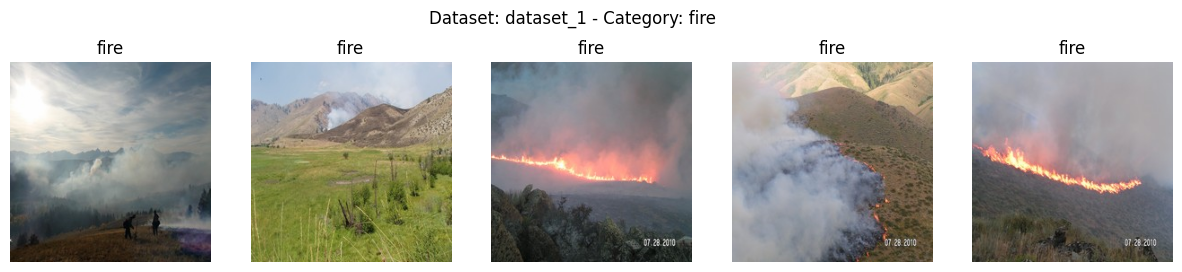

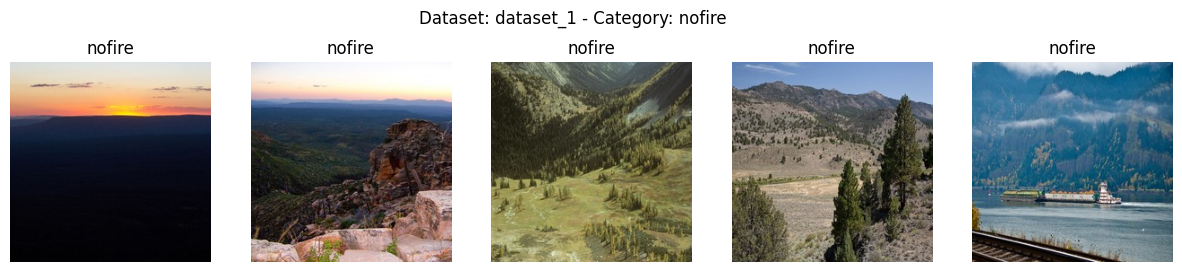

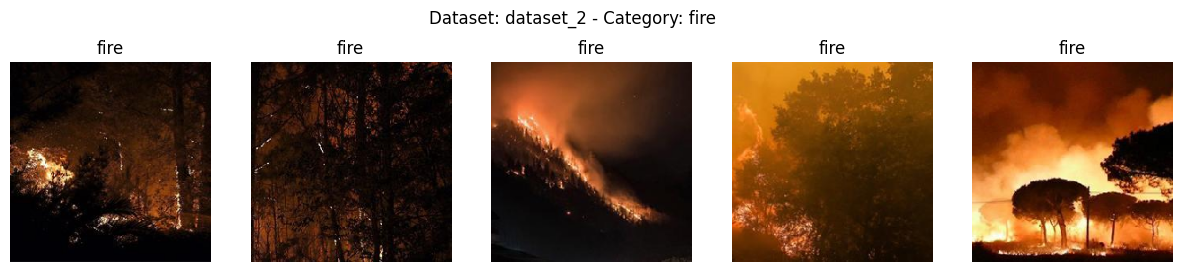

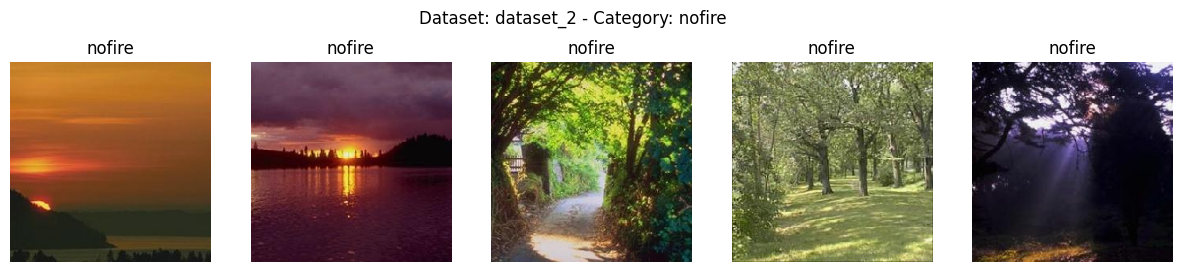

In [89]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    dataset_name = os.path.basename(os.path.dirname(directory))
    plt.suptitle(f"Dataset: {dataset_name} - Category: {category}", y=0.8)
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

for train_dir in train_dirs:
    # Plotting 5 fire and 5 nofire images
    plot_images(train_dir, 'fire', 5)
    plot_images(train_dir, 'nofire', 5)



### Model Preparation

In [ ]:
callbacks_list = [
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
ModelCheckpoint(filepath=os.path.join("tmp", 'temp_model.keras'), monitor='val_loss', save_best_only=True),
ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

metrics_list = ['accuracy', 
                    Precision(name="precision"), 
                    Recall(name="recall"), 
                    AUC(name="auc"), 
                    f1_score
                    ]

def generate_model(bm):
    if bm == CUSTOMNET:
        model = bm
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_list)
        return model
    
    base_model = bm(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False

    # Create the model
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=bm.__name__)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_list)
    return model

### Training and evaluating the models

In [ ]:
training_results = {}
run_number = len([d for d in os.listdir("runs") if os.path.isdir(os.path.join("runs", d)) and d.startswith('run_')]) + 1
run_dir = os.path.join("runs", f"run_{run_number}")
os.makedirs(run_dir, exist_ok=True)
results_file = os.path.join(run_dir, 'training_results.json')

for base_model in base_models:
    model = generate_model(base_model) # Instantiate a new model
    model.summary()
    training_results[model.name] = {}
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=os.path.join("architectures", f"{model.name}_architecture.png"))
    for dataset_name, train_dataset, val_dataset, steps_per_epoch, validation_steps in zip(combined_dataset_names, combined_training_datasets, combined_val_datasets, steps_per_epoch_list, validation_steps_list):
        model = generate_model(base_model) # Instantiate a new model
        print(f"Training model: {model.name} on dataset: {dataset_name}")
        
        # Record the start time
        start_time = time.time()

        # Initial training of the model
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks_list
        )

        # Record the end time
        end_time = time.time()
        # Calculate the training time
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")

        model_ds_dir = os.path.join(run_dir, model.name, dataset_name)
        os.makedirs(model_ds_dir, exist_ok=True)
        # Save the model
        model.save(os.path.join(model_ds_dir, f"{model.name}_{dataset_name}.keras"))

        ### Evaluation stage ###

        # Plot metrics and save the history
        plot_history(model_ds_dir, history, model.name, dataset_name)

        # Generate the ROC curve
        optimal_threshold = generate_roc_curve(model, test_generator, model_ds_dir, dataset_name)
        
        # Generate the confusion matrices, using the optimal threshold and the default threshold of 0.5
        true_labels = test_generator.classes
        test_generator.reset()
        predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()
        test_generator.reset()
        predicted_labels_optimal = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()
        cm = confusion_matrix(true_labels, predicted_labels)
        cm_optimal = confusion_matrix(true_labels, predicted_labels_optimal)
        plot_confusion_matrix(cm, model_ds_dir, model.name, dataset_name)
        plot_confusion_matrix(cm_optimal, model_ds_dir, model.name, dataset_name, optimal=True)

        # Plot the test images with predictions
        plot_test_images(test_generator, model_ds_dir, dataset_name, model, 0.5)
        plot_test_images(test_generator, model_ds_dir, dataset_name, model, optimal_threshold, optimal=True)
        
        training_results[model.name][dataset_name] = {
            'history': history.history,
            'training_time': training_time,
            'optimal_threshold': float(optimal_threshold),
            "evaluation": model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size)
        }
        
        print(training_results)

        # Save the training results to a file after each iteration
        with open(results_file, 'w') as f:
            json.dump(training_results, f, indent=4)
        
        

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

Training model: ResNet50V2 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 57s 608ms/step - accuracy: 0.7669 - auc: 0.8374 - f1_score: 13.3464 - loss: 0.5793 - precision: 0.6960 - recall: 0.7582 - val_accuracy: 0.8984 - val_auc: 0.9776 - val_f1_score: 11.8322 - val_loss: 0.2289 - val_precision: 0.9394 - val_recall: 0.8000
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 52s 596ms/step - accuracy: 0.8641 - auc: 0.9404 - f1_score: 12.9402 - loss: 0.3329 - precision: 0.8231 - recall: 0.8447 - val_accuracy: 0.9271 - val_auc: 0.9863 - val_f1_score: 12.0237 - val_loss: 0.1955 - val_precision: 0.9706 - val_recall: 0.8462
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 52s 598ms/step - accuracy: 0.8890 - auc: 0.9535 - f1_score: 13.3981 - loss: 0.2894 - precision: 0.8509 - recall: 0.8870 - val_accuracy: 0.9245 - val_auc: 0.9923 - val_f1_score: 11.5578 - val_loss: 0.1638 - val_precision: 0.9692 - val_recall: 0.8344
Epoch 4/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 53s 604ms/step - accuracy: 0.8917 - auc: 0.9608 - f1

d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.8510 - auc: 0.9337 - f1_score: 19.0193 - loss: 0.3483 - precision: 0.8981 - recall: 0.8534
{'ResNet50V2': {'dataset_1': {'history': {'accuracy': [0.8142959475517273, 0.8782327771186829, 0.8900862336158752, 0.8969109058380127, 0.9055315852165222, 0.9087643623352051, 0.9166666865348816, 0.9141523241996765, 0.9274425506591797, 0.9317528605461121, 0.9299569129943848, 0.9339080452919006, 0.9461206793785095], 'auc': [0.8898626565933228, 0.9488478302955627, 0.9560935497283936, 0.9655328392982483, 0.967765748500824, 0.9712526798248291, 0.9733210206031799, 0.9774035811424255, 0.9801322221755981, 0.9825494885444641, 0.9809852242469788, 0.9834827184677124, 0.9875323176383972], 'f1_score': [13.243277549743652, 13.124202728271484, 13.41789436340332, 

Model: "InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336,801 (85.21 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

Training model: InceptionV3 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 470ms/step - accuracy: 0.7895 - auc: 0.8773 - f1_score: 14.0147 - loss: 0.5658 - precision: 0.7206 - recall: 0.8085 - val_accuracy: 0.8932 - val_auc: 0.9796 - val_f1_score: 10.6455 - val_loss: 0.2532 - val_precision: 0.9735 - val_recall: 0.7432
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.8756 - auc: 0.9479 - f1_score: 13.3208 - loss: 0.3131 - precision: 0.8380 - recall: 0.8672 - val_accuracy: 0.9349 - val_auc: 0.9848 - val_f1_score: 13.5801 - val_loss: 0.1661 - val_precision: 0.9152 - val_recall: 0.9321
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.8948 - auc: 0.9607 - f1_score: 13.3831 - loss: 0.2593 - precision: 0.8593 - recall: 0.8916 - val_accuracy: 0.9323 - val_auc: 0.9900 - val_f1_score: 12.7614 - val_loss: 0.1639 - val_precision: 0.9792 - val_recall: 0.8598
Training time: 146.89 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step
15/15 ━━━━━━━━━━━━

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_408         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_409         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,345 (56.65 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Training model: VGG16 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6660 - auc: 0.7248 - f1_score: 13.2533 - loss: 0.7060 - precision: 0.5747 - recall: 0.6377 - val_accuracy: 0.7031 - val_auc: 0.9008 - val_f1_score: 5.9134 - val_loss: 0.5483 - val_precision: 0.9583 - val_recall: 0.2911
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7896 - auc: 0.8668 - f1_score: 12.7134 - loss: 0.4768 - precision: 0.7504 - recall: 0.7275 - val_accuracy: 0.7786 - val_auc: 0.9317 - val_f1_score: 7.7800 - val_loss: 0.4545 - val_precision: 0.9167 - val_recall: 0.4552
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8005 - auc: 0.8789 - f1_score: 12.6266 - loss: 0.4591 - precision: 0.7602 - recall: 0.7429 - val_accuracy: 0.7682 - val_auc: 0.9087 - val_f1_score: 8.4388 - val_loss: 0.4615 - val_precision: 0.9091 - val_recall: 0.4605
Training time: 444.73 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/s

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_416         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_417         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,159,041 (76.90 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 20,025,920 (76.39 MB)

Training model: VGG19 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6690 - auc: 0.7235 - f1_score: 13.5959 - loss: 0.7323 - precision: 0.5944 - recall: 0.6563 - val_accuracy: 0.6224 - val_auc: 0.8896 - val_f1_score: 0.5932 - val_loss: 0.6199 - val_precision: 1.0000 - val_recall: 0.0268
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7562 - auc: 0.8319 - f1_score: 12.9589 - loss: 0.5518 - precision: 0.7098 - recall: 0.7002 - val_accuracy: 0.6068 - val_auc: 0.8908 - val_f1_score: 1.0430 - val_loss: 0.6896 - val_precision: 1.0000 - val_recall: 0.0443
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7867 - auc: 0.8720 - f1_score: 12.9225 - loss: 0.4612 - precision: 0.7424 - recall: 0.7378 - val_accuracy: 0.6693 - val_auc: 0.9261 - val_f1_score: 1.9877 - val_loss: 0.5450 - val_precision: 1.0000 - val_recall: 0.0993
Training time: 547.81 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/s

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_428         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_429         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,395,497 (81.62 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

Training model: Xception on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 828ms/step - accuracy: 0.7955 - auc: 0.8789 - f1_score: 13.6335 - loss: 0.5197 - precision: 0.7202 - recall: 0.8138 - val_accuracy: 0.8516 - val_auc: 0.9552 - val_f1_score: 11.5186 - val_loss: 0.3386 - val_precision: 0.9262 - val_recall: 0.7019
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 816ms/step - accuracy: 0.8561 - auc: 0.9298 - f1_score: 13.0171 - loss: 0.3637 - precision: 0.8092 - recall: 0.8410 - val_accuracy: 0.8750 - val_auc: 0.9690 - val_f1_score: 11.8399 - val_loss: 0.3094 - val_precision: 0.9603 - val_recall: 0.7378
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 69s 796ms/step - accuracy: 0.8786 - auc: 0.9521 - f1_score: 13.0781 - loss: 0.2824 - precision: 0.8443 - recall: 0.8624 - val_accuracy: 0.9349 - val_auc: 0.9856 - val_f1_score: 12.4031 - val_loss: 0.2142 - val_precision: 0.9514 - val_recall: 0.8839
Training time: 215.18 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 746ms/step
15/15 ━━━━━━━━━━━━━━

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_28     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_448         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_449         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,321 (9.89 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Training model: MobileNetV2 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.7740 - auc: 0.8564 - f1_score: 14.1391 - loss: 0.5535 - precision: 0.7090 - recall: 0.7952 - val_accuracy: 0.8490 - val_auc: 0.9668 - val_f1_score: 11.1469 - val_loss: 0.3004 - val_precision: 0.9402 - val_recall: 0.6832
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - accuracy: 0.8752 - auc: 0.9467 - f1_score: 13.3869 - loss: 0.3134 - precision: 0.8344 - recall: 0.8703 - val_accuracy: 0.9193 - val_auc: 0.9738 - val_f1_score: 11.5703 - val_loss: 0.2002 - val_precision: 0.8921 - val_recall: 0.8857
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.8619 - auc: 0.9398 - f1_score: 13.7540 - loss: 0.3315 - precision: 0.8438 - recall: 0.8380 - val_accuracy: 0.9453 - val_auc: 0.9865 - val_f1_score: 12.6902 - val_loss: 0.1465 - val_precision: 0.9404 - val_recall: 0.9221
Training time: 56.49 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step
15/15 ━━━━━━━━━━━━━

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_32     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_456         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_457         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,281 (27.87 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

Training model: DenseNet121 on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 717ms/step - accuracy: 0.7835 - auc: 0.8631 - f1_score: 14.0471 - loss: 0.5114 - precision: 0.7124 - recall: 0.8083 - val_accuracy: 0.9193 - val_auc: 0.9723 - val_f1_score: 13.8299 - val_loss: 0.2395 - val_precision: 0.8728 - val_recall: 0.9438
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 690ms/step - accuracy: 0.8708 - auc: 0.9430 - f1_score: 13.2684 - loss: 0.3314 - precision: 0.8128 - recall: 0.8829 - val_accuracy: 0.9089 - val_auc: 0.9725 - val_f1_score: 13.0152 - val_loss: 0.2124 - val_precision: 0.8854 - val_recall: 0.8910
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 691ms/step - accuracy: 0.9009 - auc: 0.9587 - f1_score: 12.5794 - loss: 0.2644 - precision: 0.8618 - recall: 0.8880 - val_accuracy: 0.9115 - val_auc: 0.9781 - val_f1_score: 13.0919 - val_loss: 0.1976 - val_precision: 0.8758 - val_recall: 0.9097
Training time: 190.84 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 759ms/step
15/15 ━━━━━━━━━━━

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_36     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_464         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_465         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,665,697 (78.83 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 20,334,432 (77.57 MB)

Training model: EfficientNetV2S on dataset: dataset_1
Epoch 1/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 82s 796ms/step - accuracy: 0.5668 - auc: 0.5875 - f1_score: 13.4597 - loss: 0.9588 - precision: 0.4712 - recall: 0.5245 - val_accuracy: 0.6042 - val_auc: 0.6351 - val_f1_score: 10.6053 - val_loss: 0.6653 - val_precision: 0.5405 - val_recall: 0.3727
Epoch 2/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 739ms/step - accuracy: 0.6262 - auc: 0.6641 - f1_score: 12.7860 - loss: 0.7847 - precision: 0.5359 - recall: 0.5446 - val_accuracy: 0.7396 - val_auc: 0.8032 - val_f1_score: 13.1397 - val_loss: 0.6464 - val_precision: 0.6548 - val_recall: 0.7237
Epoch 3/80
87/87 ━━━━━━━━━━━━━━━━━━━━ 66s 758ms/step - accuracy: 0.6471 - auc: 0.6761 - f1_score: 12.4984 - loss: 0.7035 - precision: 0.5822 - recall: 0.5359 - val_accuracy: 0.7057 - val_auc: 0.7775 - val_f1_score: 11.0293 - val_loss: 0.6210 - val_precision: 0.6694 - val_recall: 0.5260
Training time: 212.07 seconds
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 832ms/step
15/15 ━━━━━━━

In [ ]:
from pprint import pprint
pprint(history.history)
print(model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size))

{'accuracy': [0.6144266724586487, 0.6494361162185669, 0.6569548845291138],
 'auc': [0.6367918848991394, 0.6824052333831787, 0.6998791694641113],
 'f1_score': [13.05825138092041, 12.414570808410645, 12.266820907592773],
 'loss': [0.8181612491607666, 0.6991491913795471, 0.6522251963615417],
 'precision': [0.5282280445098877, 0.5811227560043335, 0.5851528644561768],
 'recall': [0.542479932308197, 0.5367521643638611, 0.541257917881012],
 'val_accuracy': [0.6861979365348816, 0.6953125, 0.6953125],
 'val_auc': [0.7404367923736572, 0.7918170690536499, 0.7563954591751099],
 'val_f1_score': [12.92343807220459, 9.041755676269531, 12.567973136901855],
 'val_loss': [0.6538417935371399, 0.6154076457023621, 0.5959376096725464],
 'val_precision': [0.625806450843811, 0.7109826803207397, 0.6539792418479919],
 'val_recall': [0.6081504821777344, 0.4006514549255371, 0.5851393342018127]}
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step - accuracy: 0.6164 - auc: 0.6730 - f1_score: 19.0668 - loss: 0.6748 - precision

In [97]:
model.summary()

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_39     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_470         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_471         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,328,229 (81.36 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 20,334,432 (77.57 MB)

 Optimizer params: 662,532 (2.53 MB)